In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from pathlib import Path
from pyEllipse import hotelling_parameters, hotelling_coordinates, confidence_ellipse

In [6]:
img_dir = Path("images")
img_dir.mkdir(exist_ok=True)
plt.style.use('seaborn-v0_8-darkgrid') 

In [7]:
def load_wine_data():
    """Load wine dataset and add cultivar labels"""
    wine_df = pd.read_csv('data/wine.csv')
    
    # Add cultivar labels based on standard Wine dataset structure
    cultivar = []
    for i in range(len(wine_df)):
        if i < 59:
            cultivar.append('Cultivar 1')
        elif i < 130:
            cultivar.append('Cultivar 2')
        else:
            cultivar.append('Cultivar 3')
    
    wine_df['Cultivar'] = cultivar
    return wine_df

In [10]:
wine_df = load_wine_data()
X = wine_df.drop('Cultivar', axis=1)
y = wine_df['Cultivar']

In [74]:
# Perform PCA
pca = PCA()
SS = StandardScaler()
X = SS.fit_transform(X)
pca_scores = pca.fit_transform(X)
explained_var = pca.explained_variance_ratio_

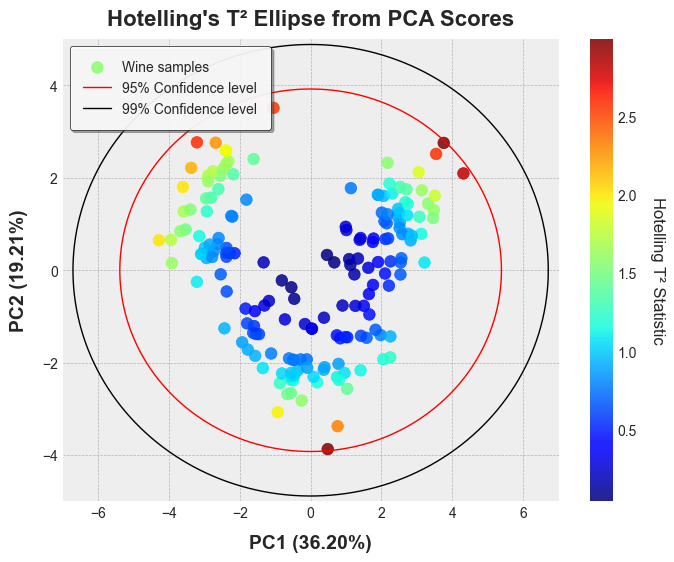

In [81]:
plt.style.use('bmh')
# Calculate T² statistics
results = hotelling_parameters(pca_scores, k=2)
t2 = results['Tsquared'].values

# Generate ellipse coordinates for plotting
ellipse_95 = hotelling_coordinates(pca_scores, pcx=1, pcy=2, conf_limit=0.95)
ellipse_99 = hotelling_coordinates(pca_scores, pcx=1, pcy=2, conf_limit=0.99)

# Plot the PCA scores with Hotelling's T² ellipse
plt.figure(figsize=(8, 6))
scatter = plt.scatter(pca_scores[:, 0], pca_scores[:, 1], c=t2, cmap='jet', alpha=0.85, s=70, label='Wine samples')
cbar = plt.colorbar(scatter)
cbar.set_label('Hotelling T² Statistic', rotation=270, labelpad=20)

plt.plot(ellipse_95['x'], ellipse_95['y'], 'r-', linewidth=1, label='95% Confidence level')
plt.plot(ellipse_99['x'], ellipse_99['y'], 'k-', linewidth=1, label='99% Confidence level')
plt.xlim(-7, 7)
plt.ylim(-5, 5)
plt.xlabel(f'PC1 ({explained_var[0]*100:.2f}%)', fontsize=14, labelpad=10, fontweight='bold')
plt.ylabel(f'PC2 ({explained_var[1]*100:.2f}%)', fontsize=14, labelpad=10, fontweight='bold')
plt.title("Hotelling's T² Ellipse from PCA Scores", fontsize=16, pad=10, fontweight='bold')
plt.legend(loc='upper left', fontsize=10, frameon=True, framealpha=0.9, edgecolor='black', shadow=True, facecolor='white', borderpad=1)
plt.show()

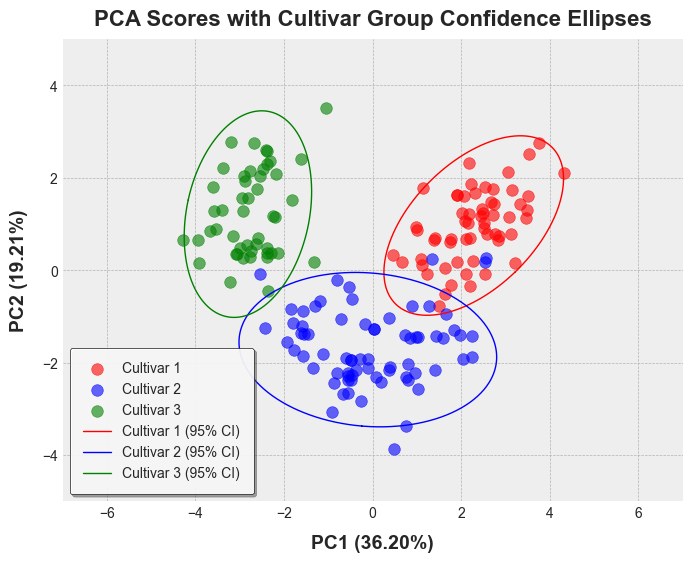

In [85]:
wine_df['PC1'] = pca_scores[:, 0]
wine_df['PC2'] = pca_scores[:, 1]

colors = ['red', 'blue', 'green']
cultivars = wine_df['Cultivar'].unique()
color_map = {cultivar: color for cultivar, color in zip(cultivars, colors)}
point_colors = wine_df['Cultivar'].map(color_map)

# Plott PCA scores with confidence ellipses for each cultivar
plt.figure(figsize=(8, 6))

for i, cultivar in enumerate(cultivars):
    mask = wine_df['Cultivar'] == cultivar
    plt.scatter(wine_df.loc[mask, 'PC1'], wine_df.loc[mask, 'PC2'], c=colors[i], alpha=0.6, s=70, label=cultivar) # type: ignore

ellipse_coords = confidence_ellipse(
    data=wine_df,
    x='PC1',
    y='PC2',
    group_by='Cultivar',
    conf_level=0.95,
    robust=True,
    distribution='hotelling'
)

for i, cultivar in enumerate(cultivars):
    ellipse_data = ellipse_coords[ellipse_coords['Cultivar'] == cultivar]
    plt.plot(ellipse_data['x'], ellipse_data['y'], color=colors[i], linewidth=1, linestyle='-', label=f'{cultivar} (95% CI)')

plt.xlim(-7, 7)
plt.ylim(-5, 5)
plt.xlabel(f'PC1 ({explained_var[0]*100:.2f}%)', fontsize=14, labelpad=10, fontweight='bold')
plt.ylabel(f'PC2 ({explained_var[1]*100:.2f}%)', fontsize=14, labelpad=10, fontweight='bold')
plt.title("PCA Scores with Cultivar Group Confidence Ellipses", fontsize=16, pad=10, fontweight='bold')
plt.legend(loc='lower left', fontsize=10, frameon=True, framealpha=0.9, edgecolor='black', shadow=True, facecolor='white', borderpad=1)
plt.show()

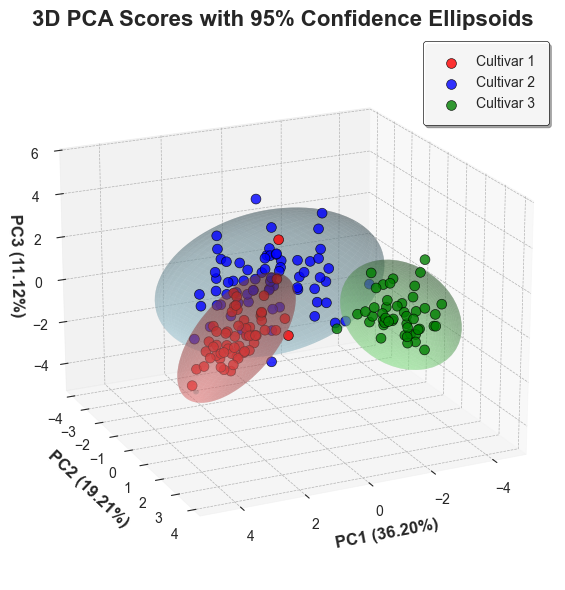

In [86]:
wine_df['PC1'] = pca_scores[:, 0]
wine_df['PC2'] = pca_scores[:, 1]
wine_df['PC3'] = pca_scores[:, 2]

colors = ['red', 'blue', 'green']
light_colors = ['lightcoral', 'lightblue', 'lightgreen']
cultivars = wine_df['Cultivar'].unique()

ellipse_coords = confidence_ellipse(
    data=wine_df,
    x='PC1',
    y='PC2',
    z='PC3',
    group_by='Cultivar',
    conf_level=0.95,
    robust=True,
    distribution='hotelling'
)

fig = plt.figure(figsize=(10, 6), facecolor='white')
ax = fig.add_subplot(111, projection='3d', facecolor='white')

for i, cultivar in enumerate(cultivars):
    mask = wine_df['Cultivar'] == cultivar
    ax.scatter(
        wine_df.loc[mask, 'PC1'], 
        wine_df.loc[mask, 'PC2'], 
        wine_df.loc[mask, 'PC3'], # type: ignore
        c=colors[i], 
        alpha=0.8, 
        s=50, 
        label=cultivar, 
        edgecolors='black', 
        linewidth=0.5
        )
     
    ellipse_data = ellipse_coords[ellipse_coords['Cultivar'] == cultivar]
    n_points = int(np.sqrt(len(ellipse_data)))
    
    x_2d = ellipse_data['x'].values.reshape(n_points, -1)
    y_2d = ellipse_data['y'].values.reshape(n_points, -1)
    z_2d = ellipse_data['z'].values.reshape(n_points, -1)
    
    ax.plot_surface(
        x_2d, 
        y_2d, 
        z_2d, 
        color=light_colors[i], 
        alpha=0.4, 
        linewidth=0, 
        antialiased=True
        )

ax.set_xlabel(f'PC1 ({explained_var[0]*100:.2f}%)', fontsize=12, labelpad=5, fontweight='bold')
ax.set_ylabel(f'PC2 ({explained_var[1]*100:.2f}%)', fontsize=12, labelpad=5, fontweight='bold')
ax.set_zlabel(f'PC3 ({explained_var[2]*100:.2f}%)', fontsize=12, labelpad=1, fontweight='bold')
ax.set_title('3D PCA Scores with 95% Confidence Ellipsoids', fontsize=16, fontweight='bold')
ax.legend(loc='upper right', fontsize=10, frameon=True, framealpha=0.9, edgecolor='black', shadow=True, facecolor='white', borderpad=1)
ax.grid(True, alpha=0.3, color='gray')
ax.view_init(elev=20, azim=65)
plt.tight_layout()
plt.show()